In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

image_paths = [
    "1.jpg", "2.jpg", "3.jpg", "4.jpg"  
]
background_path = "back.jpg"

In [3]:
background = cv2.imread(background_path, cv2.IMREAD_GRAYSCALE)
background = cv2.resize(background, (800, 800)) 
background = background / 255.0  

trajectory_points = []

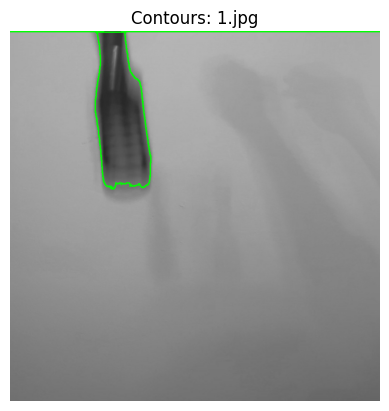

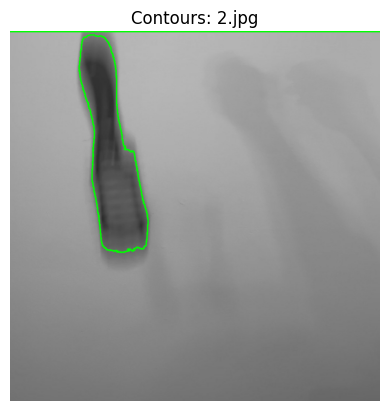

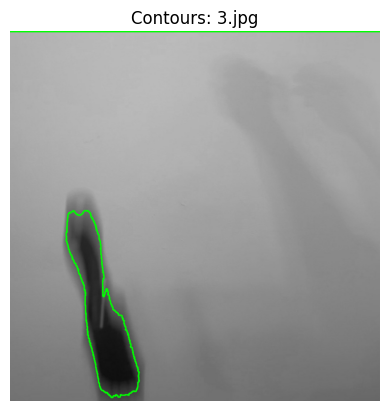

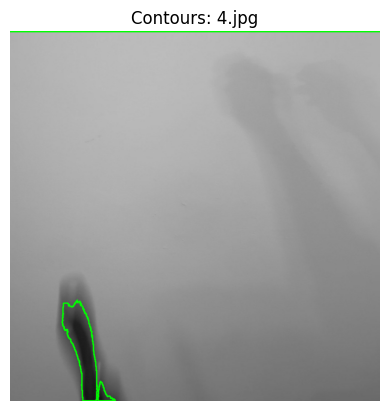

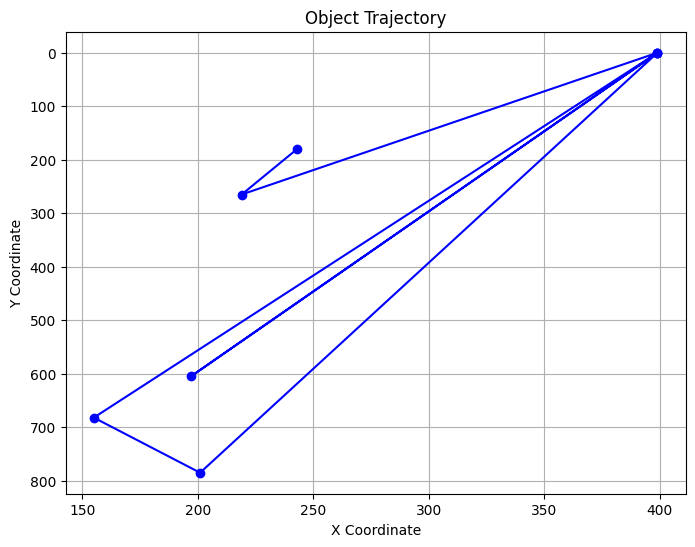

In [4]:
for image_path in image_paths:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Не удалось загрузить {image_path}")
        continue

    image = cv2.resize(image, (background.shape[1], background.shape[0]))
    image = image / 255.0

    diff = cv2.absdiff(image, background)
    _, diff_thresh = cv2.threshold(diff, 0.2, 1.0, cv2.THRESH_BINARY)

    diff_thresh = (diff_thresh * 255).astype(np.uint8)

    contours, _ = cv2.findContours(diff_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    min_area = 50
    filtered_contours = [c for c in contours if cv2.contourArea(c) > min_area]

    for contour in filtered_contours:
        moments = cv2.moments(contour)
        if moments["m00"] != 0:
            cx = int(moments["m10"] / moments["m00"])
            cy = int(moments["m01"] / moments["m00"])
            trajectory_points.append((cx, cy))

    debug_image = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    cv2.drawContours(debug_image, filtered_contours, -1, (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(debug_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Contours: {image_path}")
    plt.axis('off')
    plt.show()

if trajectory_points:
    x_coords, y_coords = zip(*trajectory_points)
    plt.figure(figsize=(8, 6))
    plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b')
    plt.gca().invert_yaxis()
    plt.title("Object Trajectory")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.grid(True)
    plt.show()
else:
    print("Точки траектории не найдены!")


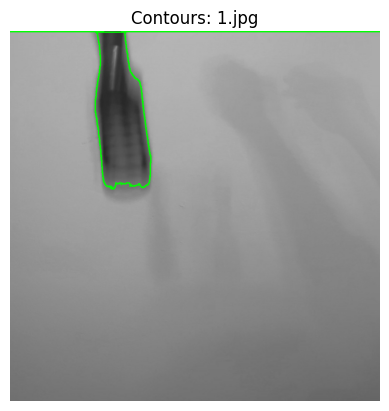

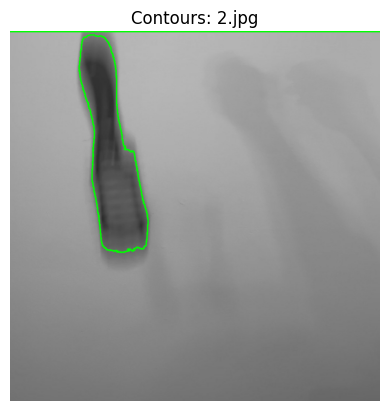

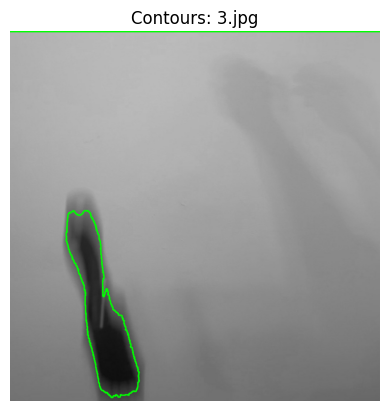

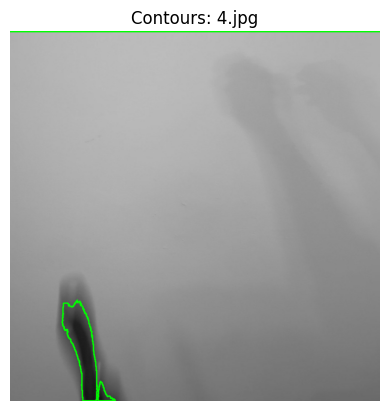

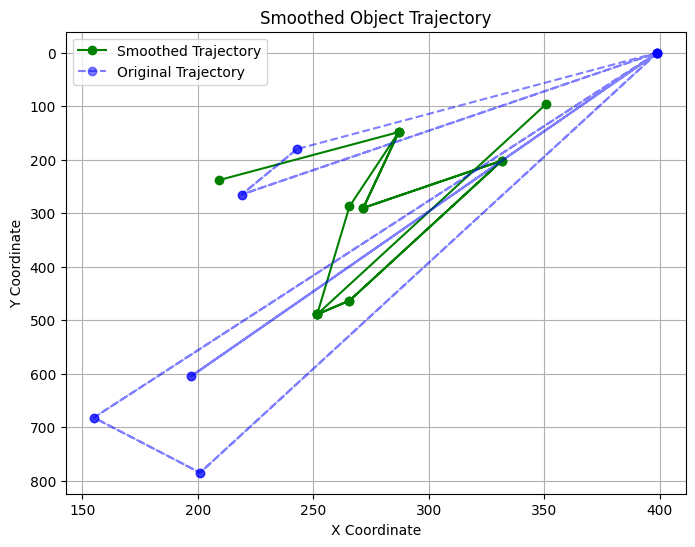

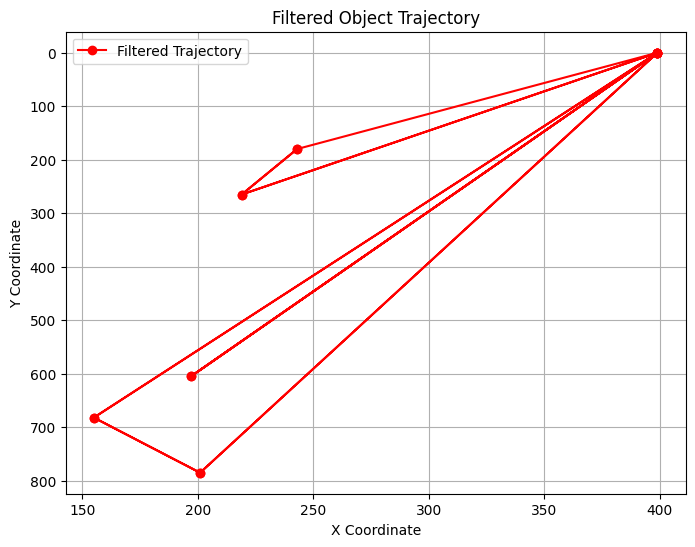

In [5]:
from scipy.signal import savgol_filter

for image_path in image_paths:
    image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
    if image is None:
        print(f"Не удалось загрузить {image_path}")
        continue

    image = cv2.resize(image, (background.shape[1], background.shape[0]))
    image = image / 255.0

    diff = cv2.absdiff(image, background)
    _, diff_thresh = cv2.threshold(diff, 0.2, 1.0, cv2.THRESH_BINARY)

    diff_thresh = (diff_thresh * 255).astype(np.uint8)
    contours, _ = cv2.findContours(diff_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    min_area = 50
    filtered_contours = [c for c in contours if cv2.contourArea(c) > min_area]

    for contour in filtered_contours:
        moments = cv2.moments(contour)
        if moments["m00"] != 0:
            cx = int(moments["m10"] / moments["m00"])
            cy = int(moments["m01"] / moments["m00"])
            trajectory_points.append((cx, cy))

    debug_image = cv2.cvtColor((image * 255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    cv2.drawContours(debug_image, filtered_contours, -1, (0, 255, 0), 2)
    plt.imshow(cv2.cvtColor(debug_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Contours: {image_path}")
    plt.axis('off')
    plt.show()

if trajectory_points:
    x_coords, y_coords = zip(*trajectory_points)

    if len(x_coords) > 3:
        x_smooth = savgol_filter(x_coords, 3, 1)
        y_smooth = savgol_filter(y_coords, 3, 1)

        plt.figure(figsize=(8, 6))
        plt.plot(x_smooth, y_smooth, marker='o', linestyle='-', color='g', label='Smoothed Trajectory')
        plt.plot(x_coords, y_coords, marker='o', linestyle='--', color='b', alpha=0.5, label='Original Trajectory')
        plt.gca().invert_yaxis()
        plt.title("Smoothed Object Trajectory")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        plt.grid(True)
        plt.show()
    else:
        print("Недостаточно точек для сглаживания траектории.")

    filtered_trajectory = [(x_coords[0], y_coords[0])]
    for i in range(1, len(x_coords)):
        dx = x_coords[i] - filtered_trajectory[-1][0]
        dy = y_coords[i] - filtered_trajectory[-1][1]
        distance = (dx**2 + dy**2)**0.5
        if distance > 10:
            filtered_trajectory.append((x_coords[i], y_coords[i]))

    if len(filtered_trajectory) > 1:
        x_filt, y_filt = zip(*filtered_trajectory)
        plt.figure(figsize=(8, 6))
        plt.plot(x_filt, y_filt, marker='o', linestyle='-', color='r', label='Filtered Trajectory')
        plt.gca().invert_yaxis()
        plt.title("Filtered Object Trajectory")
        plt.xlabel("X Coordinate")
        plt.ylabel("Y Coordinate")
        plt.legend()
        plt.grid(True)
        plt.show()
else:
    print("Точки траектории не найдены!")


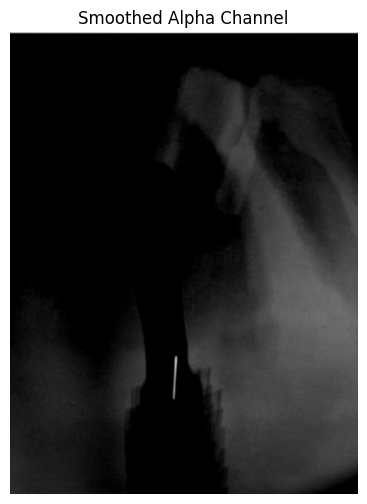

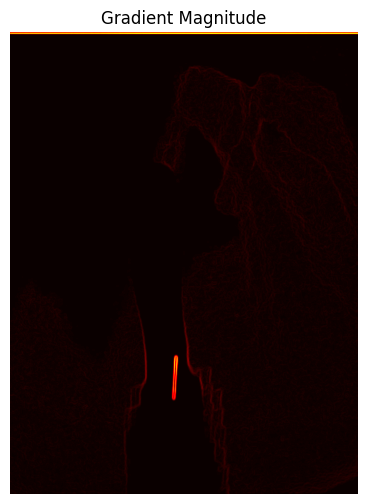

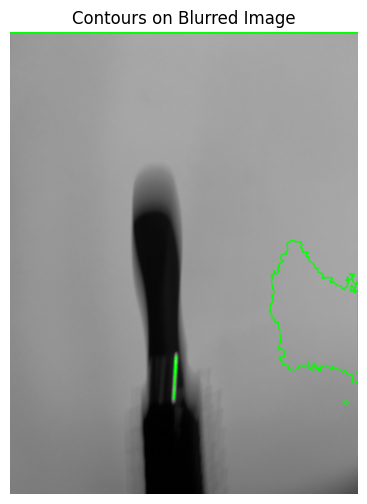

In [6]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

background_path = "back.jpg"
motion_blurred_path = "blurred.jpg"

background = cv2.imread(background_path, cv2.IMREAD_GRAYSCALE) / 255.0
motion_blurred = cv2.imread(motion_blurred_path, cv2.IMREAD_GRAYSCALE) / 255.0

height, width = background.shape
motion_blurred = cv2.resize(motion_blurred, (width, height))

alpha = np.clip((motion_blurred - background) / (1 - background), 0, 1)

alpha_smoothed = cv2.GaussianBlur(alpha, (7, 7), 0)

grad_x = cv2.Sobel(alpha_smoothed, cv2.CV_64F, 1, 0, ksize=5)
grad_y = cv2.Sobel(alpha_smoothed, cv2.CV_64F, 0, 1, ksize=5)
gradient_magnitude = np.sqrt(grad_x**2 + grad_y**2)

_, alpha_thresh = cv2.threshold(alpha_smoothed, 0.2, 1.0, cv2.THRESH_BINARY)
alpha_thresh = (alpha_thresh * 255).astype(np.uint8)

contours, _ = cv2.findContours(alpha_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

min_area = 50
filtered_contours = [c for c in contours if cv2.contourArea(c) > min_area]

trajectory_points = []
for contour in filtered_contours:
    moments = cv2.moments(contour)
    if moments['m00'] != 0:
        cx = int(moments['m10'] / moments['m00'])
        cy = int(moments['m01'] / moments['m00'])
        trajectory_points.append((cx, cy))

plt.figure(figsize=(8, 6))
plt.imshow(alpha_smoothed, cmap='gray')
plt.title("Smoothed Alpha Channel")
plt.axis('off')
plt.show()

plt.figure(figsize=(8, 6))
plt.imshow(gradient_magnitude, cmap='hot')
plt.title("Gradient Magnitude")
plt.axis('off')
plt.show()

contour_image = (motion_blurred * 255).astype(np.uint8)
contour_image = cv2.cvtColor(contour_image, cv2.COLOR_GRAY2BGR)
cv2.drawContours(contour_image, filtered_contours, -1, (0, 255, 0), 2)
plt.figure(figsize=(8, 6))
plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
plt.title("Contours on Blurred Image")
plt.axis('off')
plt.show()


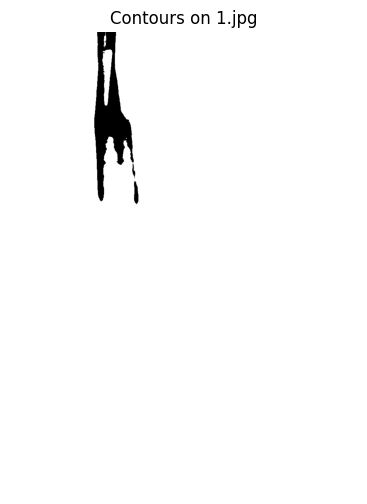

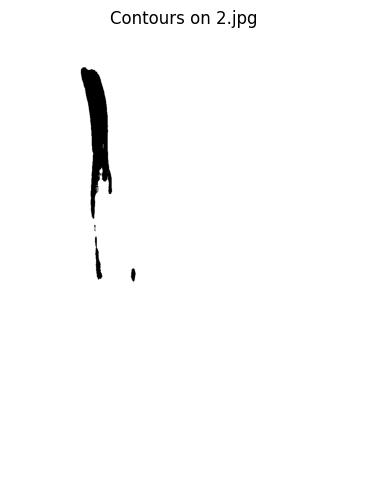

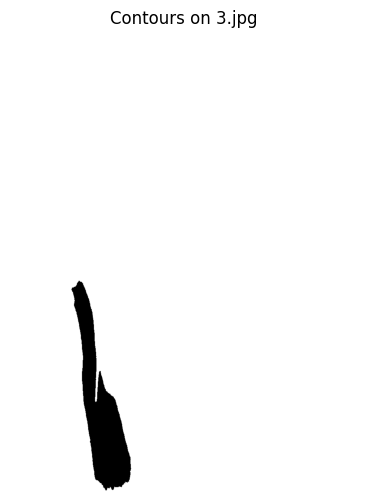

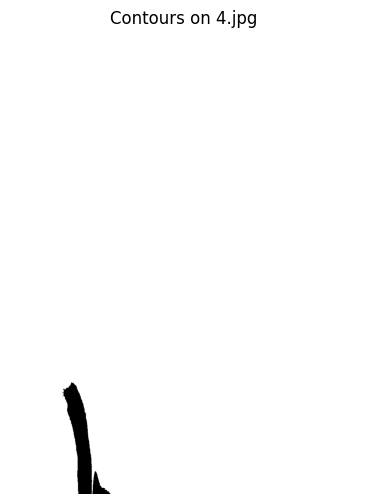

In [7]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

background_path = "back.jpg"
image_paths = ["1.jpg", "2.jpg", "3.jpg", "4.jpg"]

background = cv2.imread(background_path, cv2.IMREAD_GRAYSCALE) / 255.0

height, width = background.shape

trajectory_points = []

for image_path in image_paths:
    motion_blurred = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) / 255.0
    motion_blurred = cv2.resize(motion_blurred, (width, height))

    alpha = np.clip((motion_blurred - background) / (1 - background), 0, 1)
    motion_blurred = cv2.convertScaleAbs(motion_blurred, alpha=2.0, beta=0)
    alpha_smoothed = alpha

    brightness_mask = (motion_blurred > 0.4).astype(np.uint8)
    _, alpha_thresh = cv2.threshold(alpha_smoothed, 0.3, 1.0, cv2.THRESH_BINARY)
    alpha_thresh = cv2.bitwise_and((alpha_thresh * 255).astype(np.uint8), brightness_mask)

    contours, _ = cv2.findContours(alpha_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    filtered_contours = [
        c for c in contours if cv2.contourArea(c) > 50 and 0.5 < cv2.boundingRect(c)[2] / cv2.boundingRect(c)[3] < 2.0
    ]

    contour_image = (motion_blurred * 255).astype(np.uint8)
    contour_image = cv2.cvtColor(contour_image, cv2.COLOR_GRAY2BGR)
    cv2.drawContours(contour_image, filtered_contours, -1, (0, 255, 0), 2)
    plt.figure(figsize=(8, 6))
    plt.imshow(cv2.cvtColor(contour_image, cv2.COLOR_BGR2RGB))
    plt.title(f"Contours on {image_path}")
    plt.axis('off')
    plt.show()


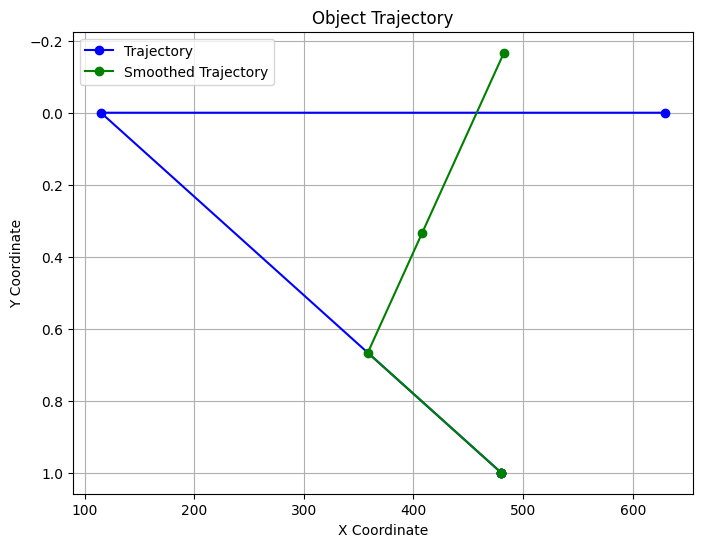

In [8]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import savgol_filter

background_path = "back.jpg"
image_paths = ["1.jpg", "2.jpg", "3.jpg", "4.jpg"]

background = cv2.imread(background_path, cv2.IMREAD_GRAYSCALE) / 255.0

height, width = background.shape

trajectory_points = []

for image_path in image_paths:
    motion_blurred = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE) / 255.0
    motion_blurred = cv2.resize(motion_blurred, (width, height))

    alpha = np.clip((motion_blurred - background) / (1 - background), 0, 1)
    motion_blurred = cv2.convertScaleAbs(motion_blurred, alpha=2.0, beta=0)

    brightness_mask = (motion_blurred > 0.4).astype(np.uint8)
    _, alpha_thresh = cv2.threshold(alpha, 0.3, 1.0, cv2.THRESH_BINARY)
    alpha_thresh = cv2.bitwise_and((alpha_thresh * 255).astype(np.uint8), brightness_mask)

    contours, _ = cv2.findContours(alpha_thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    min_area = 200
    filtered_contours = [c for c in contours if cv2.contourArea(c) > min_area]

    for contour in filtered_contours:
        moments = cv2.moments(contour)
        if moments['m00'] != 0:
            cx = int(moments['m10'] / moments['m00'])
            cy = int(moments['m01'] / moments['m00'])
            trajectory_points.append((cx, cy))

trajectory_points.sort(key=lambda p: p[1])

if trajectory_points:
    x_coords, y_coords = zip(*trajectory_points)
    plt.figure(figsize=(8, 6))
    plt.plot(x_coords, y_coords, marker='o', linestyle='-', color='b', label='Trajectory')

    if len(x_coords) > 3:
        x_smooth = savgol_filter(x_coords, 3, 1)
        y_smooth = savgol_filter(y_coords, 3, 1)
        plt.plot(x_smooth, y_smooth, marker='o', linestyle='-', color='g', label='Smoothed Trajectory')

    plt.gca().invert_yaxis()
    plt.title("Object Trajectory")
    plt.xlabel("X Coordinate")
    plt.ylabel("Y Coordinate")
    plt.legend()
    plt.grid(True)
    plt.show()
else:
    print("Траектория не найдена.")
